%%HTML
<style>

.CodeMirror {
    width: 100vw;
}

.container {
    width: 99% !important;
}

.rendered_html {
  font-size:0.8em;
}
.rendered_html table, .rendered_html th, .rendered_html tr, .rendered_html td {
     font-size: 100%;
}

</style>

## Hypothesis Testing
<br>
<center>
<img src="../images/ibm-logo-bw.png" alt="ibm-logo" align="center" style="width: 200px;"/>
</center>

Data scientists employ a broad range of statistical tools to analyze data and reach conclusions from sometimes messy and incomplete data. Many of these tools come from classical statistics and are used before the formal modeling part of the workflow.  This unit focuses on the foundational techniques of estimation with probability distributions and simple hypothesis tests in the context of EDA.

In [1]:
import re
import os
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from termcolor import cprint
from IPython.display import Image
import matplotlib.pyplot as plt

plt.style.use('seaborn')
%matplotlib inline

SMALL_SIZE = 10
MEDIUM_SIZE = 11
LARGE_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=LARGE_SIZE)   # fontsize of the figure title

def slide_print(text, color='white'):
    cprint(text, color, 'on_grey')

> <span style="color:orange">Statistical Inference</span>: the theory, methods, and practice of forming judgments about the parameters of a population and the reliability of statistical relationships, typically on the basis of random sampling.

<br></br>
A <span style="color:orange">population</span> is a set of similar items or events which is of interest for some question or experiment. It is generally difficult or impossible to sample from the entire population so we rely on
<span style="color:orange">random sampling</span> techniques to ensure that our sample is a good representation of the population.

Statistical inference is a very complex discipline, but fortunately there are tools that make its application routine. Thinking about your data with in terms of statistical populations and random sampling is foundational to the methods described in this section.  We will discuss how statistical inference is used to answer the following types of questions.

### Applications of Statistical Inference

<span style="color:orange">Hypothesis Testing</span>: How well does the data match some assumed (null) distribution?

<span style="color:orange">Point Estimation</span>: What instance of some distributional class does it match well?

<span style="color:orange">Uncertainty Estimation</span>: How can we quantify our degree of uncertainty about our estimates?

<span style="color:orange">Sensitivity Analysis</span>: Do our results rely heavily on our distributional assumptions?

All of these types are questions are typical for an investigative analysis.  We may be looking to uncover the connection between the business opportunity and the data or we may be looking to understand a trend or pattern in the data.  Hypothesis testing, point estimation, uncertainty estimation, and sensitivity analysis are all examples of where we rely on statistical inference to do the heavy lifting.  Before we jump into the investigation example let's think for a moment about a simple application of statistical inference.  Lets imagine that there is a devops unit within the AAVAIL company that allocates computational resources for other units in the company. **END OF PART 1**.

In [2]:
def plot_beta_distributions():
    """
    takes the alpha (a) and beta (b) parameters from a beta distribution
    produces a plot with both the original and the inferred
    """

    fig = plt.figure(figsize=(10,4),dpi=150,facecolor='white')
    splot = 0
    
    ## loop through parameterizations of the beta
    for a,b in [(5,1),(5,2),(5,5)]:
        splot += 1
        ax = fig.add_subplot(1,3,splot)
        beta_dist = stats.beta(a,b)
        beta_rvs = beta_dist.rvs(size=1000)
        pdf_range = np.linspace(beta_dist.ppf(0.0001),beta_dist.ppf(0.9999), 100)
        ax.hist(beta_rvs,bins=60,facecolor="royalblue",alpha=0.7,density=1,histtype='stepfilled')
        ax.plot(pdf_range, beta_dist.pdf(pdf_range), 'darkorange', lw=4)
        ax.set_xlim((0,1))
        ax.set_title(r"$\alpha$=%s, $\beta$=%s"%(a,b))
        ax.set_aspect(1./ax.get_data_ratio())
    

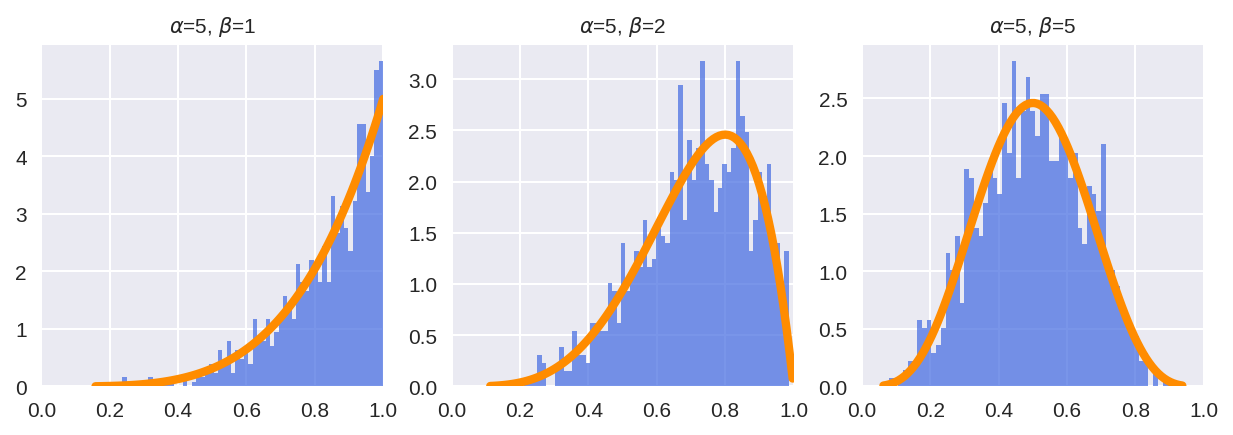

In [3]:
plot_beta_distributions()

 Lets say the data are the percentage of time CPUs are allocated each day. For each day we might have 50%, 80% or another number.  Any of these subplots could be a representative sample of the population.  First we are going to use a beta distribution to generate some data for this example.  Then we are going to fit it with another distribution and make probability statements about the data.  You may recall that the beta distribution, governed by the $\alpha$ and $\beta$ parameters is very flexible as seen here.

In [4]:
def infer_gaussian_from_beta(a,b):
    """
    takes the alpha (a) and beta (b) parameters from a beta distribution
    produces a plot with both the original and the inferred
    """

    ## plot the beta
    fig = plt.figure(figsize=(10,4),dpi=160,facecolor='white')
    ax = fig.add_subplot(111)
    beta_dist = stats.beta(a,b)
    beta_rvs = beta_dist.rvs(size=2000)
    pdf_range = np.linspace(beta_dist.ppf(0.0001),beta_dist.ppf(0.9999), 100)
    ax.hist(beta_rvs,bins=60,facecolor="royalblue",alpha=0.7,density=1,histtype='stepfilled')
    ax.plot(pdf_range, beta_dist.pdf(pdf_range), 'darkorange', lw=3, label="Beta")
    
    ## inference 
    mu_hat,sigma_hat = stats.norm.fit(beta_rvs)
    
    ## plot inferred pdf
    norm_dist = stats.norm(loc=mu_hat,scale=sigma_hat)
    norm_rvs = norm_dist.rvs(size=1000)
    pdf_range = np.linspace(norm_dist.ppf(0.0001), norm_dist.ppf(0.9999), 100)
    ax.plot(pdf_range, norm_dist.pdf(pdf_range),color='black',linestyle='dashed',lw=3,label="Gaussian")
    ax.set_aspect(1./ax.get_data_ratio())
    ax.set_xlim((-.1,1.1))
    ax.legend(loc='upper left')
    
    ## annotate the axis
    text = r"$\alpha$=%s, $\beta$=%s"%(a,b) + "\n"
    text += r"$\hat{\mu}$=%s, $\hat{\sigma}$=%s"%(round(mu_hat,2),round(sigma_hat,2))
    ax.annotate(text, xy=(0.01,0.7), xycoords='axes fraction',
                 xytext=(0.02,0.68), textcoords='axes fraction',
                 bbox=dict(boxstyle="round", fc="0.8"))
   
    return(norm_dist,beta_dist)

This function demonstrates the process of statistical inference on a dataset.  We first instaintiate a beta distribution given the input parameters. We create a histogram of 2000 samples drawn from the distribution and then evaluate the pdf for most possible values.  The plotting code takes up most of the function and is less important here than the single line needed for inference.  To summarize the function we use a beta distribution to represent our given data and then we infer a Gaussian using the dot fit method.  The estimated parameters are denoted with conventional hat notation.

Estimated Probability: 0.003
True Probability: 0.001


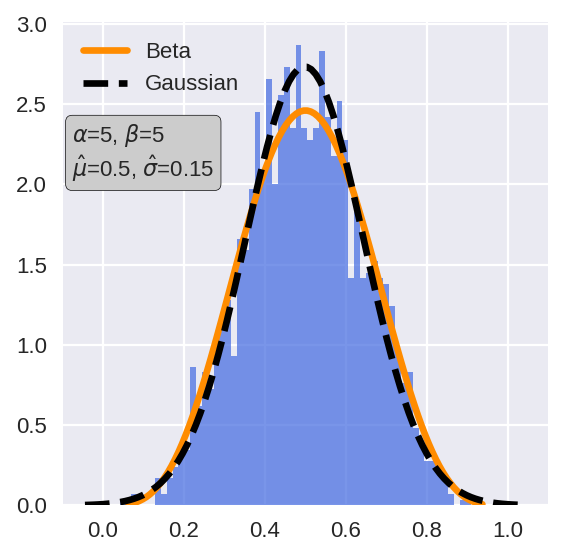

In [5]:
norm_dist,beta_dist = infer_gaussian_from_beta(5,5) # (5,1),(5,2),(5,5)

## what is the probability that more than 90% of processors are being used at any one time?
slide_print("Estimated Probability: {}".format(round(1-norm_dist.cdf(0.90),3)))
slide_print("True Probability: {}".format(round(1-beta_dist.cdf(0.90),3)))

The historgram represents the random samples from the specified beta distribution and the lines are the corresponding pdfs.  The goal here is to make probability statements that are meaningful even to non-technical stakeholders.  For example... READ.  We can answer this using the cdf as shown. We see that the probabilities from the assumed and actual distributions are close.  Given a reasonable fit we can make statements like on average there is a 12% probability that more than 90% of processors being allocated.  

Lets first see what happens when we our assumed distribution is not longer appropriate for the given data

There is a noticeable difference between the two probabilities.

Next lets align the assumed and actual distributions 

We see that the probabilities tend to converge.  Despite the ease with which these statements can be made it is important remember that visualization provides credibility and context that is important when using statistical inference to make probability statements. **END OF PART 2**

<span style="color:orange">Numerical Optimization</span>

   * Maximum Likelihood
   * Expectation Maximization (EM)

<span style="color:orange">Simulation</span>

   * Bootstrapping
   * Permutation Testing
   * Monte Carlo Methods
   
<span style="color:orange">Estimation of Posterior Distributions</span>
   
   * Markov Chain Monte Carlo (MCMC)
   * Variational Methods

<span style="color:orange">Nonparametric Estimation</span>

   * Bayesian Non-parametrics 

The fit we just used in the previous slide was computed by maximizing a log-likelihood function. There are many ways to carry out inference.  Depending on the choice of method there are inherent advantages and disadvantages... like computational complexity, bias and flexibility.  Let's dive into an example that showcases several of these inference methods in the context of a EDA investigation.

   > Visitors to the AAVAIL website are randomly sent to version A or version B of the website. Let’s assume that version B has a new marketing scheme for getting a user to click ‘subscribe’ and version A is the default version.  In order to investigate whether version B has a greater impact on purchase decisions we will track the number of visitors to each version and keep track of the proportion that convert to becoming subscribers.

In data science, hypothesis tests often take the form of A/B tests where there are control and treatment groups of samples.  We are going to work with the following example for the remainder of this lesson.  READ IT!

## Hypothesis testing

1. **Pose your question**

   * Do visitors to sites A and B convert (i.e. become subscribers) at different rates? 

2. **Specify a null $H_{0}$ and alternative $H_{1}$ hypotheses** 

   * $H_{0}$ The conversion rate is the same between sites A and B
   * $H_{1}$ The conversion rate is different between sites A and B

3. **Choose a specific hypothesis test and level of significance**

   * Binomial Test, $\alpha=0.05$
   
4. **Collect data**

   * Track visitors to site a specified period of time, randomly sending each to either A or B

5. **Run the test**

   * Calculate the test statistic and determine a $p$-value

6. **Evaluate the results**

   * You will fail to reject the null hypothesis or you will reject it in favor of the alternative

Recall the basic process behind hypothesis testing.  If we decided to use a binomial test then the procedure would look like the steps enumerated here.  From a scientific thinking perspective we are trying to disprove all other possible explanations before accepting that website B is more or less effective than website A.  It is important to remember that we decide on a test and the level of significance before collecting the data.  In the context of modern data science 'collecting data' could refer to the process of loading it into pandas, because data is often being accumulated in some form for most organizations.

In [6]:
def simulate_data(n,p):
    """
    The probability of success in a single trial follows a Bernoulli distribution. 
    We can simulate visitors to the site by running repeated Bernoulli trials.
    """
    
    results = stats.bernoulli(p).rvs(n)
    converts = np.sum(results)
    slide_print("We observed {} conversions out of {} visitors".format(converts, n))
    return(results)

p_a = 0.12                          # the long term conversion rate for website 'a'             
p_b = 0.20                          # the 'unknown' conversion rate for website 'b'

np.random.seed(42)                  # use a random seed to ensure the repeatability
results = simulate_data(100,p_b)

We observed 18 conversions out of 100 visitors


Since we are simulating the data we can specify the 'unknown' conversion rates for both versions of the website.  In reality these are values that we estimate.  In a typical A/B test we would be comparing two versions of the site running concurrently, because we want to account for as many unmeasured effects as possible like seasonality, time of day effects and more.  This would be a two-sample hypothesis test.  Because many organizations are not always willing to run experiments in this way let’s start with a one-sample test and ask the question if there is a difference between site B and the historical baseline.

In [7]:
## run a binomial test
baseline_probability = p_a
p_value = stats.binom_test(np.sum(results), n=results.size, p=baseline_probability)
slide_print("binomial test p-value: {}".format(round(p_value,4)))

binomial test p-value: 0.0878


If the p-value is less than 0.05 we reject the null hypothesis the conversion rate is the same as the historical conversion rate, in favor of the alternative.  It is important that you do not stop your investigation here... it is also important that you do not make critical business decisions based on a single p-value.  We will discuss some limitations of p-values in later sections.  This p-value should be considered alongside other forms of evidence before making decisions. **END OF PART 3** 

#### The expected distribution

In [8]:
expected_dist = stats.binom(n=results.size,p=p_a)
mu = expected_dist.mean()
sd = expected_dist.std()
slide_print("The expected distribution the site is mu={}, sd={}".format(mu,round(sd,3)))

The expected distribution the site is mu=12.0, sd=3.25


We can also think of the A/B test from a generative perspective.  That is samples are generated by repeated Bernoulli trials, and these follow a Binomial distribution. So we can specify the baseline as follows.  Let p be the long term conversion rate, in this case it is the rate observed from site A.  And let the parameter 'n' be the number of samples in our experiment.  We will use this distribution to give us and idea of what is expected given the null or baseline distribution.

#### One-sample Z-test for difference in proportions

$$
z = \frac{\hat{p}-\frac{1}{2} - p_{0}}{\sigma}
$$

In [9]:
expected_dist = stats.binom(n=results.size,p=p_a)
p0 = expected_dist.mean()
sd = expected_dist.std()
z = (np.sum(results)-0.5-p0) / sd
pvalue = 2*(1 - stats.norm.cdf(z))
slide_print("normal approximation p-value: {}".format(round(p_value,3)))

normal approximation p-value: 0.088


The binomial test is an example of an exact solution.  If the number of visitors increases beyond a few thousand it becomes reasonable to use an normal distribution to approximate the estimated proportion. The test statistic in this case is a z-score shown by the formula above.  The numerator is the difference between our estimated conversion rate and the baseline.  The one half is additionally subtracted as a continuity correction.  This is necessary when we approximate discrete distributions with continuous ones.  The denominator is the estimate for the standard deviation.  We see that the p-value is similar to the exact test in this case.

#### Permutation test

The distribution of the test statistic under the null hypothesis is obtained by calculating a very large number of possible values. 

In [10]:
nsamples = 100000
n = results.size
p = p_a
slide_print("n={}, p={}".format(n,p))
xs = np.random.binomial(n, p, nsamples)
p_value = 2*np.sum(xs >= np.sum(results))/xs.size
slide_print("simulation p-value: {}".format(round(p_value,3)))

n=100, p=0.12
simulation p-value: 0.1


It is also possible to take a numerical approach to calculating these probabilities. In this example we repeatedly generate success counts from a binomial distribution with specified n and p. We then track how many of those success counts were greater than or equal to the observed number of conversions from site B. The proportion, after a large number of simulations converges towards the p-value that tests the hypothesis of equality between the two site conversion rates.

#### Maximum likelihood estimation

> When business decisions are made on the basis of a particular estimate then the context provided by the bootstrap method provides an additional source of information to help make those decisions.

In [11]:
bs_samples = np.random.choice(results, (nsamples, len(results)), replace=True)
bs_ps = np.mean(bs_samples, axis=1)
bs_ps.sort()

print("Maximum Likelihood Estimate:%s"%(np.sum(results)/float(len(results))))
print("Bootstrap CI: (%.4f, %.4f)"%(bs_ps[int(0.025*nsamples)], bs_ps[int(0.975*nsamples)]))

Maximum Likelihood Estimate:0.18
Bootstrap CI: (0.1100, 0.2600)


Maximum Likelihood Estimation (MLE)

We have seen an example of maximum likelihood estimation in the example about probabilities and CPU usage.  One significant caveat to this kind of estimation is that we are left with a point estimate that has little context.  Here we take the point estimation a step further and quantify the distribution of that estimate using the bootstrap. **END OF PART 4**

#### Bayesian estimation

Recall that we are trying to update our degree of belief by combining 'prior' information with our likelihood.

$$
p(\theta|x) = \frac{p(x|\theta)p(\theta)}{p(x)}
$$

* <span style="color:orange">Prior</span> - $p(\theta)$ - belief about a quantity before presented with evidence
* <span style="color:orange">Posterior</span> - $p(\theta|x)$ - probability of the parameters given the evidence
* <span style="color:orange">Likelihood</span> - $p(x|\theta)$ - probability of the evidence given the parameters
* Normalizing Constant - $p(x)$ - helps ensure a valid probability

The Bayesian treatment for comparing conversion rates for sites A and B is very similar to the MLE approach when combined with a bootstrap confidence interval. Point estimates are not obtained directly, instead there is a posterior distribution that corresponds to, in this case $\hat{p}$.  Bayes formula and the relevant terms are shown on this slide as a reminder.

In [12]:
def bayes_one_sample_proportaions(p_a,p_b,n=100):
    """
    use the conjugate prior to estimate the posterior
    """
    
    fig = plt.figure(figsize=(10,4),dpi=160,facecolor='white')
    ax = fig.add_subplot(111)

    np.random.seed(42)
    results = simulate_data(n,p_b)

    expected_dist = stats.binom(n=results.size,p=p_a)
    mu = expected_dist.mean()
    sd = expected_dist.std()
    slide_print(r"Given the baseline we expected on average {} conversions".format(int(mu)))
    p_value = stats.binom_test(np.sum(results), n=results.size, p=p_a)
    slide_print("binomial test p-value: {}".format(round(p_value,4)))
    
    converts = np.sum(results)
    a, b = 1, 1
    prior = stats.beta(a, b)
    post = stats.beta(converts+a, n-converts+b)
    ci = post.interval(0.95)
    map_ =(converts+a-1.0)/(n+a+b-2.0)

    xs = np.linspace(0, 1, n)
    ax.plot(prior.pdf(xs), label='Prior')
    ax.plot(post.pdf(xs), label='Posterior')
    
    maxval = (0.05 * post.pdf(xs).max()) + post.pdf(xs).max()
    linerange = np.linspace(0,maxval,100)
    ci_range = np.linspace(ci[0],ci[1],100)
    ax.plot(ci_range*n,[0.05*maxval]*100, c='black', linewidth=2, label='95% CI');
    ax.plot([n*p_a]*100,linerange,c='darkred',linestyle='solid',linewidth=5,alpha=0.5,label=r'$p_{a}$')
    ax.plot([n*p_b]*100,linerange,c='gold', linestyle='solid',linewidth=5,alpha=0.5,label=r'$p_{b}$')
    ax.plot([n*map_]*100,linerange,c='royalblue', linestyle='dashed', alpha=0.9,label=r'$\hat{p_{b}}$')
    ax.set_ylim((0,maxval))
    ax.legend()

For this example we demonstrate here an analytical solution that makes use of a conjugate prior over the binomial distribution. For most real life problems the necessary statistical models are more complex and estimation makes use of numerical methods like Markov Chain Monte Carlo.  The conjugate prior of the Binomial is the Beta distribution.  The prior distribution, in this case a beta, with both parameters equal to 1 results in a uniform distribution, which happens to be ideal when we want our prior to be uninformative.  We encourage you to come back to this function later on, but try not to get caught up in too many of the details your first time through.  

We observed 199 conversions out of 1000 visitors
Given the baseline we expected on average 120 conversions
binomial test p-value: 0.0


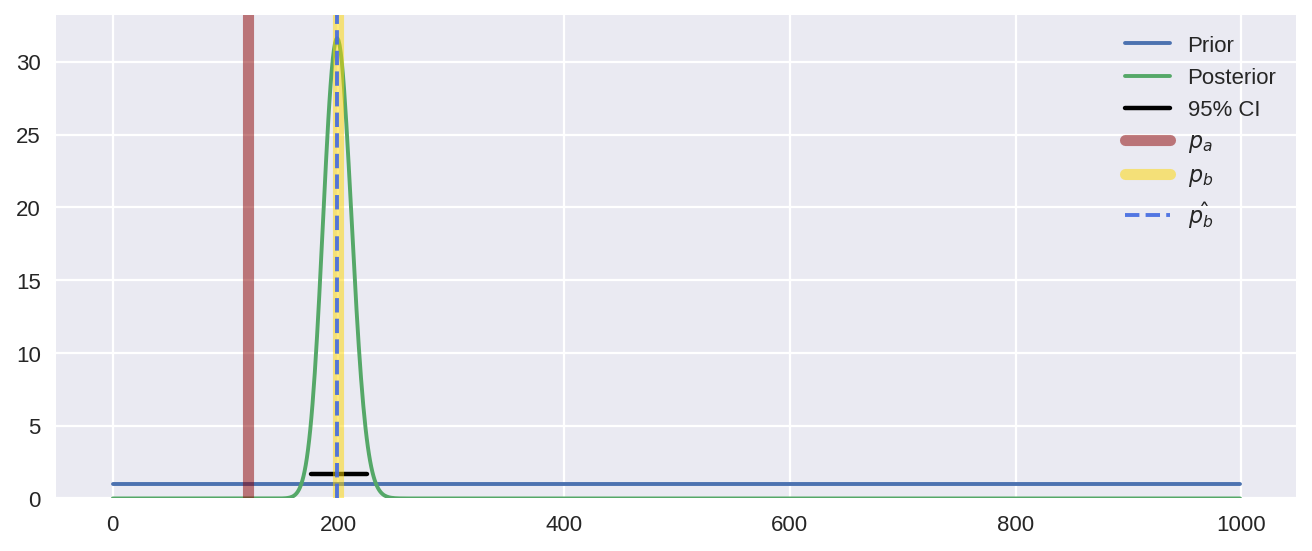

In [18]:
p_a = 0.12                                      # the long term conversion rate for website 'a'
p_b = 0.20                                      # the 'unknown' conversion rate for website 'b'
bayes_one_sample_proportaions(p_a,p_b,n=1000)

We are interested in the question whether the conversion rate from B is different from that of A.  Normally we do not know the actual conversion rate for site B, but we have plotted it here in yellow to see how well our dashed blue estimate aligns.  With more data these two lines will converge.  The historical expected number of conversions is shown in red and as a rule of thumb if our confidence interval overlaps it then we cannot be confident that the two conversion rates are different.  It is an intuitive way of essentially running a hypothesis test where there is no need to set a level of $\alpha$.  

1. First lets increase n (change n to 500)

We see that as the sample size increases the known and empirically estimated conversion rates converge

2. Then lets increas n some more (change n to 1000)

At even higher sample sizes we see the confidence intervals shrink to reflect an increased degree of belief

Note that this setup naturally accepts new data by setting your posteriors as your prior and repeating this process. We encourage you to explore this solution and dig deeper into related readings on solutions to the multi-armed bandit problem.